In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(13320, 9) (1480, 9)


In [3]:
train['source'] = 'Train'
test['source'] = 'Test'

data =  pd.concat([train, test], ignore_index=True)
print(data.shape)
data.reset_index(inplace=True) # I will join the price for the test set at the end using this column
data = data.rename(columns={'index': 'first_ind'})
data.head() 

(14800, 10)


,first_ind,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,Train
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,Train
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,Train
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,Train
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,Train


In [4]:
test_df = data[data['source']=='Test']
test_df.to_csv('submission_test_file.csv', index=False)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_ind     14800 non-null  int64  
 1   area_type     14800 non-null  object 
 2   availability  14800 non-null  object 
 3   location      14799 non-null  object 
 4   size          14782 non-null  object 
 5   society       8672 non-null   object 
 6   total_sqft    14800 non-null  object 
 7   bath          14720 non-null  float64
 8   balcony       14122 non-null  float64
 9   price         13320 non-null  float64
 10  source        14800 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


Dropping features that won´t be necessary:

In [6]:
data.drop(['availability', 'society'], axis=1, inplace=True)

Apart from that, total_sqft feature has not been infered as numeric. Lets fix that column before proceeding with the exploratory data analysis.

Values can´t be converted into numeric:

In [7]:
total_sqft = data['total_sqft'].values.tolist()
not_numeric = []

for i in range(len(total_sqft)):
    try:
        float(total_sqft[i])
    except:
        not_numeric.append(total_sqft[i])

In [8]:
not_numeric[:10]

['2100 - 2850',
 '3010 - 3410',
 '2957 - 3450',
 '3067 - 8156',
 '1042 - 1105',
 '1145 - 1340',
 '1015 - 1540',
 '1520 - 1740',
 '34.46Sq. Meter',
 '1195 - 1440']

Some values are given as a range while others can be specified in other units. I will fix the range first:

In [9]:
def mean_sqft (x):
    elements = x.split('-')
    if len(elements) == 2:
        return (float(elements[0]) + float(elements[1]))/2
    else: 
        return x

In [10]:
data['total_sqft'] = data['total_sqft'].apply(mean_sqft)

total_sqft = data['total_sqft'].values.tolist()
not_numeric = []

for i in range(len(total_sqft)):
    try:
        float(total_sqft[i])
    except:
        not_numeric.append(total_sqft[i])

In [11]:
not_numeric[:10]

['34.46Sq. Meter',
 '4125Perch',
 '1000Sq. Meter',
 '1100Sq. Yards',
 '5.31Acres',
 '30Acres',
 '716Sq. Meter',
 '1500Sq. Meter',
 '142.61Sq. Meter',
 '1574Sq. Yards']

Now there are only values in other units. I will define a function to convert those to square feet:

In [12]:
def convert_to_sqft (df, measure, equivalence_in_sqft):
    df_temp = df[df.total_sqft.str.contains(measure, na=False)]
    if df_temp.shape[0]>0:
        df_temp = df_temp.total_sqft.str.split(pat = measure, expand=True)
        df_temp.drop(columns = 1,inplace = True)
        df_temp.columns = ['total_sqft']
        df_temp.total_sqft = df_temp.total_sqft.astype(float) * equivalence_in_sqft
        ind = df_temp.index.values.tolist()

        for i in ind:
            df.loc[i, 'total_sqft'] = df_temp.loc[i, 'total_sqft']
    
    return df;

In [13]:
convert_to_sqft(data, 'Sq. Yards', 9)
convert_to_sqft(data, 'Guntha', 1.089)
convert_to_sqft(data, 'Acres', 43560)
convert_to_sqft(data, 'Sq. Meter', 10.7639)
convert_to_sqft(data, 'Perch', 272.25)
convert_to_sqft(data, 'Cents', 435.6)
convert_to_sqft(data, 'Ground', 2400)

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source
0,0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,Train
1,1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,Train
2,2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,Train
3,3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,Train
4,4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00,Train
...,...,...,...,...,...,...,...,...,...
14795,14795,Super built-up Area,Vittasandra,2 BHK,1246,2.0,1.0,NaN,Test
14796,14796,Super built-up Area,Gottigere,3 BHK,1660,3.0,2.0,NaN,Test
14797,14797,Super built-up Area,Channasandra,2 BHK,1216,2.0,2.0,NaN,Test
14798,14798,Built-up Area,Tumkur Road,2 BHK,996,2.0,1.0,NaN,Test


In [14]:
total_sqft = data['total_sqft'].values.tolist()
not_numeric = []

for i in range(len(total_sqft)):
    try:
        float(total_sqft[i])
    except:
        not_numeric.append(total_sqft[i])

In [15]:
not_numeric

[]

Now, all the elements of total_sqft can be converted into numeric.

In [16]:
data.total_sqft = data.total_sqft.astype(float)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_ind   14800 non-null  int64  
 1   area_type   14800 non-null  object 
 2   location    14799 non-null  object 
 3   size        14782 non-null  object 
 4   total_sqft  14800 non-null  float64
 5   bath        14720 non-null  float64
 6   balcony     14122 non-null  float64
 7   price       13320 non-null  float64
 8   source      14800 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 1.0+ MB


# Null Values

In [18]:
null_values = data.isnull().sum()
null_count = data.isnull().count() #Counts the number of rows
missing_perc = round(null_values/null_count * 100, 2)
df_missing = pd.DataFrame({'Null_Values': null_values, 'Percentage': missing_perc})
print(df_missing)

            Null_Values  Percentage
first_ind             0        0.00
area_type             0        0.00
location              1        0.01
size                 18        0.12
total_sqft            0        0.00
bath                 80        0.54
balcony             678        4.58
price              1480       10.00
source                0        0.00


<AxesSubplot:>

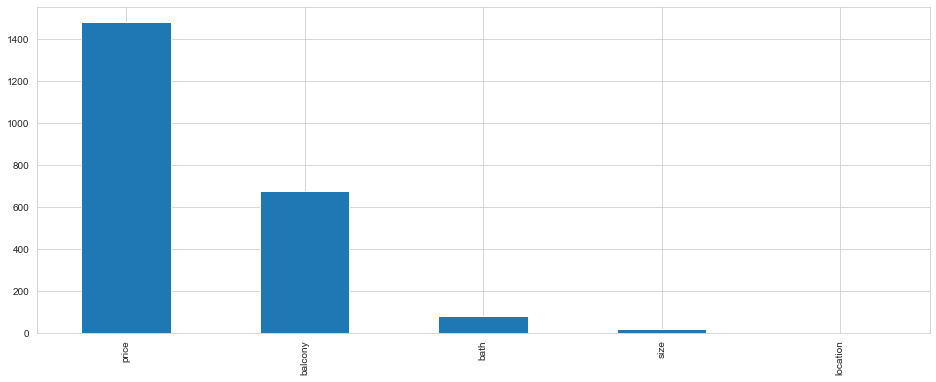

In [19]:
sns.set_style("whitegrid")
bars = df_missing.loc[df_missing['Percentage'].astype(float)>0]['Null_Values']
#.plot.bar(y='Percentage', figsize=(16,6))
bars.sort_values(ascending=False).plot(kind='bar', figsize=(16,6))

**All missing values within price column belong to the test set.**

## Imputing null values

### Location

Since there is only one null value, I could simply drop that row but instead I will impute the location with the mode of the houses that have the same area_type and size.

In [20]:
from scipy.stats import mode

In [21]:
artypeloc = data.loc[data['location'].isnull(), 'area_type'].values
sizeloc   = data.loc[data['location'].isnull(), 'size'].values

In [22]:
value = data.loc[(data['area_type']==artypeloc[0]) & (data['size']==sizeloc[0]), 'location'].mode()
value[0]

'Sarjapur  Road'

In [23]:
print('Orignal #missing: %d'% sum(data['location'].isnull()))
data.loc[data['location'].isnull(), 'location'] = value[0]
print ('Final #missing: %d'% sum(data['location'].isnull()))

Orignal #missing: 1
Final #missing: 0


### Size

The most related variable to feature size is probably the area (total_sqft) so I will be using that one to determine which size fits best to missing values.

In [24]:
data.loc[data['size'].isnull()]

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source
579,579,Plot Area,Sarjapur Road,NaN,1800.0,NaN,NaN,34.185,Train
1775,1775,Plot Area,IVC Road,NaN,3817.0,NaN,NaN,124.000,Train
2264,2264,Plot Area,Banashankari,NaN,2400.0,NaN,NaN,460.000,Train
2809,2809,Plot Area,Sarjapur Road,NaN,1800.0,NaN,NaN,28.785,Train
2862,2862,Plot Area,Devanahalli,NaN,1950.0,NaN,NaN,46.800,Train
5333,5333,Plot Area,Devanahalli,NaN,3752.5,NaN,NaN,177.115,Train
6423,6423,Plot Area,Whitefield,NaN,2324.0,NaN,NaN,26.730,Train
6636,6636,Plot Area,Jigani,NaN,1500.0,NaN,NaN,25.490,Train
6719,6719,Plot Area,Hoskote,NaN,1730.0,NaN,NaN,28.545,Train
7680,7680,Plot Area,Kasavanhalli,NaN,5000.0,NaN,NaN,400.000,Train


I am going to extract maximum and minimum values of total_sqft and divide it into the different number of categories that exists for the size column. This way I will create different ranges to impute null values here:

In [25]:
# Max and min of the null set
max_sqft = data.loc[data['size'].isnull(), 'total_sqft'].max()
min_sqft = data.loc[data['size'].isnull(), 'total_sqft'].min()

# Different categories of size that are within max and min values +-50
size_categories = len(data.loc[(data['total_sqft']<=max_sqft+50) & (data['total_sqft']>=min_sqft-50),'size'].unique())

step = (max_sqft-min_sqft)/size_categories

print(min_sqft, max_sqft, step)

1350.0 5000.0 140.3846153846154


Now I will create a dataframe that will contain the limits of each category:

In [26]:
l_lim = [round(min_sqft+i*step, 1) for i in range(size_categories)]
u_lim = [round(min_sqft+i*step, 1) for i in range(1,size_categories+1)]
limits = pd.DataFrame({'l_limit': l_lim,
                       'u_lim': u_lim})
limits

,l_limit,u_lim
0,1350.0,1490.4
1,1490.4,1630.8
2,1630.8,1771.2
3,1771.2,1911.5
4,1911.5,2051.9
5,2051.9,2192.3
6,2192.3,2332.7
7,2332.7,2473.1
8,2473.1,2613.5
9,2613.5,2753.8


In [27]:
# Add a new column with the range:
limits['interval'] = limits['l_limit'].astype(str)+'-'+limits['u_lim'].astype(str) 
limits

,l_limit,u_lim,interval
0,1350.0,1490.4,1350.0-1490.4
1,1490.4,1630.8,1490.4-1630.8
2,1630.8,1771.2,1630.8-1771.2
3,1771.2,1911.5,1771.2-1911.5
4,1911.5,2051.9,1911.5-2051.9
5,2051.9,2192.3,2051.9-2192.3
6,2192.3,2332.7,2192.3-2332.7
7,2332.7,2473.1,2332.7-2473.1
8,2473.1,2613.5,2473.1-2613.5
9,2613.5,2753.8,2613.5-2753.8


Check if sizes of the original data fall into any of the intervals:

In [28]:
data.loc[0, 'total_sqft']

1056.0

In [29]:
data.head()

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source
0,0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,Train
1,1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,Train
2,2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,Train
3,3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,Train
4,4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,Train


In [30]:
for i in range(len(data)):
    if ((data.loc[i, 'total_sqft']<=min_sqft) | (data.loc[i, 'total_sqft']>=max_sqft)):
        data.loc[i, 'interval'] = 'Out of intervals'
    else:
        for j in range(len(limits)):
            if ((data.loc[i, 'total_sqft']>limits.loc[j, 'l_limit']) & (data.loc[i, 'total_sqft']<=limits.loc[j, 'u_lim'])):
                data.loc[i, 'interval'] = limits.loc[j, 'interval']

Check the mode of each interval:

In [31]:
size_mode = data.pivot_table(values='size', columns='interval',aggfunc=(lambda x:mode(x).mode[0]) )
size_mode

interval,1350.0-1490.4,1490.4-1630.8,1630.8-1771.2,1771.2-1911.5,1911.5-2051.9,2051.9-2192.3,2192.3-2332.7,2332.7-2473.1,2473.1-2613.5,2613.5-2753.8,...,3736.5-3876.9,3876.9-4017.3,4017.3-4157.7,4157.7-4298.1,4298.1-4438.5,4438.5-4578.8,4578.8-4719.2,4719.2-4859.6,4859.6-5000.0,Out of intervals
size,3 BHK,3 BHK,3 BHK,3 BHK,3 BHK,3 BHK,3 BHK,3 BHK,3 BHK,4 BHK,...,4 Bedroom,4 BHK,4 BHK,4 Bedroom,4 Bedroom,4 BHK,4 BHK,4 Bedroom,4 Bedroom,2 BHK


Impute null values with the mode:

In [32]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['size'].isnull()

#Impute data and check #missing values before and after imputation to confirm
print('Original #missing: %d'% sum(miss_bool))
data.loc[miss_bool, 'size'] = data.loc[miss_bool, 'interval'].apply(lambda x: size_mode[x])
print('Final #missing: %d'%sum(data['size'].isnull()))

Original #missing: 18
Final #missing: 0


Now that there are no missing values I drop the interval column created:

In [33]:
data.drop(['interval'], axis=1, inplace=True)

### Bath

Next column is the number of baths. Now that the size has been imputed, we will be using that column to determine the most common number of baths for every house size:

In [34]:
#Determine the average of baths per house size:
bath_avg = data.pivot_table(values='bath', index='size')
bath_avg = bath_avg.astype(int)
bath_avg

,bath
size,
1 BHK,1
1 Bedroom,1
1 RK,1
10 BHK,12
10 Bedroom,9
11 BHK,10
11 Bedroom,8
12 Bedroom,6
13 BHK,13


In [35]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['bath'].isnull() 
miss_bool

0        False
1        False
2        False
3        False
4        False
         ...  
14795    False
14796    False
14797    False
14798    False
14799    False
Name: bath, Length: 14800, dtype: bool

In [36]:
#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool, 'bath'] = data.loc[miss_bool, 'size'].apply(lambda x: bath_avg.loc[x])
print ('Final #missing: %d'% sum(data['bath'].isnull()))

Orignal #missing: 80
Final #missing: 0


### Balcony

Last column to impute is balcony. I will follow the same process:

In [37]:
#Determine the average of baths per house size:
balc_avg = data.pivot_table(values='balcony', index='size')
balc_avg = balc_avg.astype(int)
balc_avg

,balcony
size,
1 BHK,0
1 Bedroom,0
1 RK,0
10 Bedroom,2
11 BHK,3
11 Bedroom,1
12 Bedroom,2
13 BHK,0
14 BHK,0


Since this set does not have all house sizes, I will append the rest assuming that if there is no data, that house has no balcony:

In [38]:
balc_avg.reset_index(inplace=True)

# Get all the house sizes:
all_sizes = set(data['size'].values)

# Get the ones that does not appear in the previous set:
no_balcony = list(all_sizes - set(balc_avg['size'].values))

no_balcony

['10 BHK', '18 Bedroom', '16 Bedroom', '19 BHK', '16 BHK']

In [39]:
#Create a dataframe with previous sizes and 0 balconies
no_balcony_data = pd.DataFrame({'size':no_balcony,
                               'balcony': np.zeros(len(no_balcony), dtype=int)})
no_balcony_data

,size,balcony
0,10 BHK,0
1,18 Bedroom,0
2,16 Bedroom,0
3,19 BHK,0
4,16 BHK,0


In [40]:
# Append those sizes with a value of 0:
balc_avg = pd.concat([balc_avg, no_balcony_data], ignore_index=True)
balc_avg.set_index('size', inplace=True)
balc_avg

,balcony
size,
1 BHK,0
1 Bedroom,0
1 RK,0
10 Bedroom,2
11 BHK,3
11 Bedroom,1
12 Bedroom,2
13 BHK,0
14 BHK,0


In [41]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['balcony'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool, 'balcony'] = data.loc[miss_bool, 'size'].apply(lambda x: balc_avg.loc[x])
print ('Final #missing: %d'% sum(data['balcony'].isnull()))

Orignal #missing: 678
Final #missing: 0


At this point there should be no missing values (apart from the prices that belong to testing):

In [42]:
data.isnull().sum()

first_ind        0
area_type        0
location         0
size             0
total_sqft       0
bath             0
balcony          0
price         1480
source           0
dtype: int64

In [43]:
data.describe(include='all')

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source
count,14800.000000,14800,14800,14800,1.480000e+04,14800.000000,14800.000000,13320.000000,14800
unique,NaN,4,1358,32,NaN,NaN,NaN,NaN,2
top,NaN,Super built-up Area,Whitefield,2 BHK,NaN,NaN,NaN,NaN,Train
freq,NaN,9736,591,5741,NaN,NaN,NaN,NaN,13320
mean,7399.500000,NaN,NaN,NaN,1.885323e+03,2.697973,1.555405,112.565627,NaN
std,4272.536327,NaN,NaN,NaN,1.648401e+04,1.342591,0.810790,148.971674,NaN
min,0.000000,NaN,NaN,NaN,1.000000e+00,1.000000,0.000000,8.000000,NaN
25%,3699.750000,NaN,NaN,NaN,1.100000e+03,2.000000,1.000000,50.000000,NaN
50%,7399.500000,NaN,NaN,NaN,1.280000e+03,2.000000,2.000000,72.000000,NaN
75%,11099.250000,NaN,NaN,NaN,1.688030e+03,3.000000,2.000000,120.000000,NaN


Location feature has many different values. To make it useful I will reduce the number of categories:

In [44]:
data['location'].value_counts()

Whitefield                                      591
Sarjapur  Road                                  438
Electronic City                                 337
Kanakpura Road                                  298
Thanisandra                                     277
                                               ... 
anjananager magdi road                            1
Prasanna layout Herohalli                         1
Sundar Ram Shetty Nagar                           1
2 Bedroom Furnished Farm House in Kolar Road      1
Housing Board Layout Vijay Nagar                  1
Name: location, Length: 1358, dtype: int64

There are locations that only appear once. I will group all locations that have less than 20 cases under the category of `Others`:

In [45]:
locations = data['location'].value_counts()
locations[locations.values>=20].shape[0]

160

In [46]:
#locations_to_keep = locations[locations.values>=20]
#data['location'] = data['location'].apply(lambda x: x if x in locations_to_keep else 'Other')

In [47]:
locations = locations.to_frame()
locations.reset_index(inplace=True)

In [48]:
locations.rename(columns = {'index':'location', 
                          'location':'appearances'},
                 inplace = True)
locations

,location,appearances
0,Whitefield,591
1,Sarjapur Road,438
2,Electronic City,337
3,Kanakpura Road,298
4,Thanisandra,277
...,...,...
1353,anjananager magdi road,1
1354,Prasanna layout Herohalli,1
1355,Sundar Ram Shetty Nagar,1
1356,2 Bedroom Furnished Farm House in Kolar Road,1


In [49]:
for i in range(len(locations)):
    if (locations.loc[i, 'appearances']>=20):
        locations.loc[i, 'map'] = locations.loc[i, 'location']
    else:
        locations.loc[i, 'map'] = 'Other'
locations

,location,appearances,map
0,Whitefield,591,Whitefield
1,Sarjapur Road,438,Sarjapur Road
2,Electronic City,337,Electronic City
3,Kanakpura Road,298,Kanakpura Road
4,Thanisandra,277,Thanisandra
...,...,...,...
1353,anjananager magdi road,1,Other
1354,Prasanna layout Herohalli,1,Other
1355,Sundar Ram Shetty Nagar,1,Other
1356,2 Bedroom Furnished Farm House in Kolar Road,1,Other


In [50]:
locations.drop(['appearances'], axis='columns', inplace=True)

In [51]:
data = data.merge(right=locations,
                  on='location')
data.head()

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source,map
0,0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,Train,Electronic City Phase II
1,155,Super built-up Area,Electronic City Phase II,2 BHK,1020.0,2.0,1.0,30.60,Train,Electronic City Phase II
2,292,Super built-up Area,Electronic City Phase II,2 BHK,1069.0,2.0,2.0,45.00,Train,Electronic City Phase II
3,354,Super built-up Area,Electronic City Phase II,1 BHK,630.0,1.0,1.0,28.35,Train,Electronic City Phase II
4,461,Super built-up Area,Electronic City Phase II,3 BHK,1220.0,2.0,1.0,35.23,Train,Electronic City Phase II


In [52]:
data.tail()

,first_ind,area_type,location,size,total_sqft,bath,balcony,price,source,map
14795,14686,Carpet Area,Chinnapa Garden,2 BHK,1000.0,2.0,2.0,NaN,Test,Other
14796,14697,Built-up Area,nagendra block,9 BHK,950.0,9.0,0.0,NaN,Test,Other
14797,14711,Plot Area,Raj Mahal Vilas Extension,3 Bedroom,2954.0,3.0,3.0,NaN,Test,Other
14798,14717,Plot Area,15th Block Hbr Layout,16 Bedroom,2400.0,16.0,0.0,NaN,Test,Other
14799,14792,Plot Area,Vishweswaraiah Layout 4th Block,1 Bedroom,1200.0,1.0,1.0,NaN,Test,Other


Now I will drop the original column to rename the new one:

In [53]:
data.drop(['location'], axis='columns', inplace=True)
data.rename(columns={'map':'location'}, inplace=True)
data.head()

,first_ind,area_type,size,total_sqft,bath,balcony,price,source,location
0,0,Super built-up Area,2 BHK,1056.0,2.0,1.0,39.07,Train,Electronic City Phase II
1,155,Super built-up Area,2 BHK,1020.0,2.0,1.0,30.60,Train,Electronic City Phase II
2,292,Super built-up Area,2 BHK,1069.0,2.0,2.0,45.00,Train,Electronic City Phase II
3,354,Super built-up Area,1 BHK,630.0,1.0,1.0,28.35,Train,Electronic City Phase II
4,461,Super built-up Area,3 BHK,1220.0,2.0,1.0,35.23,Train,Electronic City Phase II


# Feature Engineering

I will add a new column dividing price per square feet:

In [54]:
data['price_per_sqft'] = data['price']*1000000/data['total_sqft']

In [55]:
data.head()

,first_ind,area_type,size,total_sqft,bath,balcony,price,source,location,price_per_sqft
0,0,Super built-up Area,2 BHK,1056.0,2.0,1.0,39.07,Train,Electronic City Phase II,36998.106061
1,155,Super built-up Area,2 BHK,1020.0,2.0,1.0,30.60,Train,Electronic City Phase II,30000.000000
2,292,Super built-up Area,2 BHK,1069.0,2.0,2.0,45.00,Train,Electronic City Phase II,42095.416277
3,354,Super built-up Area,1 BHK,630.0,1.0,1.0,28.35,Train,Electronic City Phase II,45000.000000
4,461,Super built-up Area,3 BHK,1220.0,2.0,1.0,35.23,Train,Electronic City Phase II,28877.049180


In [56]:
data['price_per_sqft'].describe()

count    1.332000e+04
mean     8.090738e+04
std      1.078473e+06
min      2.257423e+01
25%      4.262295e+04
50%      5.429218e+04
75%      7.313431e+04
max      1.200000e+08
Name: price_per_sqft, dtype: float64

Also, it would be good to simplify column size with just the number of rooms:

In [57]:
data['bhk'] = data['size'].apply(lambda x: x.split(' ')[0]).astype(int)
data.drop(['size'], axis='columns', inplace=True)
data.head()

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,price_per_sqft,bhk
0,0,Super built-up Area,1056.0,2.0,1.0,39.07,Train,Electronic City Phase II,36998.106061,2
1,155,Super built-up Area,1020.0,2.0,1.0,30.60,Train,Electronic City Phase II,30000.000000,2
2,292,Super built-up Area,1069.0,2.0,2.0,45.00,Train,Electronic City Phase II,42095.416277,2
3,354,Super built-up Area,630.0,1.0,1.0,28.35,Train,Electronic City Phase II,45000.000000,1
4,461,Super built-up Area,1220.0,2.0,1.0,35.23,Train,Electronic City Phase II,28877.049180,3


I will add another column that will indicate the area per room of the house and use it to remove the outliers:

In [58]:
data['sqft_per_room'] = data['total_sqft']/data['bhk']

In [59]:
data.sort_values(by=['sqft_per_room'], ascending=True).head(20)

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,price_per_sqft,bhk,sqft_per_room
3958,4086,Plot Area,1.0000,4.0,1.0,120.0,Train,Sarjapur Road,1.200000e+08,4,0.250000
13097,4972,Built-up Area,5.0000,7.0,3.0,115.0,Train,Other,2.300000e+07,7,0.714286
8698,349,Plot Area,11.0000,3.0,2.0,74.0,Train,Other,6.727273e+06,3,3.666667
11918,1122,Built-up Area,24.0000,2.0,2.0,150.0,Train,Other,6.250000e+06,5,4.800000
14263,6552,Plot Area,26.1360,6.0,2.0,550.0,Train,Other,2.104377e+07,5,5.227200
13180,13414,Super built-up Area,40.0000,7.0,1.0,NaN,Test,Other,NaN,7,5.714286
11672,1020,Carpet Area,15.0000,1.0,0.0,30.0,Train,Other,2.000000e+06,1,15.000000
929,11558,Plot Area,60.0000,4.0,2.0,218.0,Train,Whitefield,3.633333e+06,4,15.000000
14653,11320,Plot Area,41.3820,1.0,0.0,170.0,Train,Other,4.108066e+06,1,41.382000
1733,5970,Plot Area,45.0000,1.0,0.0,23.0,Train,Mysore Road,5.111111e+05,1,45.000000


Seems logic to remove every house that is under 40 sqft per room:

In [60]:
print(data.shape)
data = data[~((data['source']=='Train') & (data['sqft_per_room']< 40))]
print(data.shape)

(14800, 11)
(14793, 11)


In [61]:
data.sort_values(by=['sqft_per_room'], ascending=False).head(20)

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,price_per_sqft,bhk,sqft_per_room
11839,1086,Plot Area,1306800.00,2.0,2.0,29.5,Train,Other,22.574227,2,653400.000000
11671,1019,Plot Area,231303.60,1.0,0.0,110.0,Train,Other,475.565447,1,231303.600000
13135,13645,Built-up Area,217800.00,1.0,0.0,NaN,Test,Other,NaN,1,217800.000000
12652,7607,Plot Area,653400.00,3.0,1.0,217.0,Train,Other,332.108968,3,217800.000000
10192,648,Built-up Area,1123031.25,9.0,1.0,265.0,Train,Other,235.968500,9,124781.250000
3506,7334,Plot Area,87120.00,1.0,0.0,125.0,Train,Kanakpura Road,1434.802571,1,87120.000000
14674,11615,Plot Area,261360.00,2.0,0.0,80.0,Train,Other,306.091215,3,87120.000000
13276,7001,Plot Area,653400.00,6.0,2.0,290.0,Train,Other,443.832262,8,81675.000000
3512,7726,Plot Area,54885.60,1.0,0.0,125.0,Train,Kanakpura Road,2277.464399,1,54885.600000
14243,6333,Plot Area,91040.40,2.0,0.0,200.0,Train,Other,2196.826903,2,45520.200000


On the other side, I will also remove houses that have more than 12000 sqft per rooom:

In [62]:
print(data.shape)
data = data[~((data['source']=='Train') & (data['sqft_per_room']>12000))]
print(data.shape)

(14793, 11)
(14781, 11)


# Outliers

## Outlier removal using price_per_sqft

In [63]:
data.reset_index(inplace=True)
data.drop(['index'], axis='columns', inplace=True)
data.head()

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,price_per_sqft,bhk,sqft_per_room
0,0,Super built-up Area,1056.0,2.0,1.0,39.07,Train,Electronic City Phase II,36998.106061,2,528.000000
1,155,Super built-up Area,1020.0,2.0,1.0,30.60,Train,Electronic City Phase II,30000.000000,2,510.000000
2,292,Super built-up Area,1069.0,2.0,2.0,45.00,Train,Electronic City Phase II,42095.416277,2,534.500000
3,354,Super built-up Area,630.0,1.0,1.0,28.35,Train,Electronic City Phase II,45000.000000,1,630.000000
4,461,Super built-up Area,1220.0,2.0,1.0,35.23,Train,Electronic City Phase II,28877.049180,3,406.666667


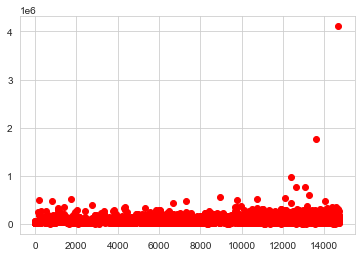

In [64]:
plt.scatter(data.index, data.price_per_sqft, color='r')

I will use the std and the mean of each location to remove outliers:

In [65]:
# First, I divide the set to keep the testing group:
train_data = data[data['source']=='Train']
test_data = data[data['source']=='Test']

In [66]:
def remove_outliers_by_location(df):
    df_out = pd.DataFrame()
    for location, tempdf in df.groupby('location'):
        m   = np.mean(tempdf['price_per_sqft'])
        std = np.std(tempdf['price_per_sqft'])
        tempdf2 = tempdf[(tempdf['price_per_sqft']>(m-std)) & (tempdf['price_per_sqft']<=(m+std))]
        df_out = pd.concat([df_out, tempdf2], ignore_index=True)
    return df_out

In [67]:
data = remove_outliers_by_location(train_data)
print(data.shape)
data = pd.concat([data, test_data], ignore_index=True)
print(test_data.shape, data.shape)

(11419, 11)
(1480, 11) (12899, 11)


In [68]:
train_data.shape

(13301, 11)

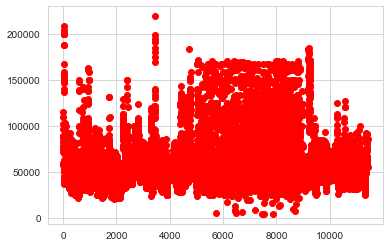

In [69]:
plt.scatter(data.index, data.price_per_sqft, color='r')

Now I will check the price for two different house sizes for a especific location:

In [70]:
def plot_scatter (df, location):
    bhk2 = df[(df['location']==location) & (df['bhk']==2)]
    bhk3 = df[(df['location']==location) & (df['bhk']==3)]
    plt.figure(figsize=(16,8))
    plt.scatter(bhk2['total_sqft'], bhk2['price'], color='lightcoral', label='2 BHK', s=50)
    plt.scatter(bhk3['total_sqft'], bhk3['price'], marker='+', color='darkslategray', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

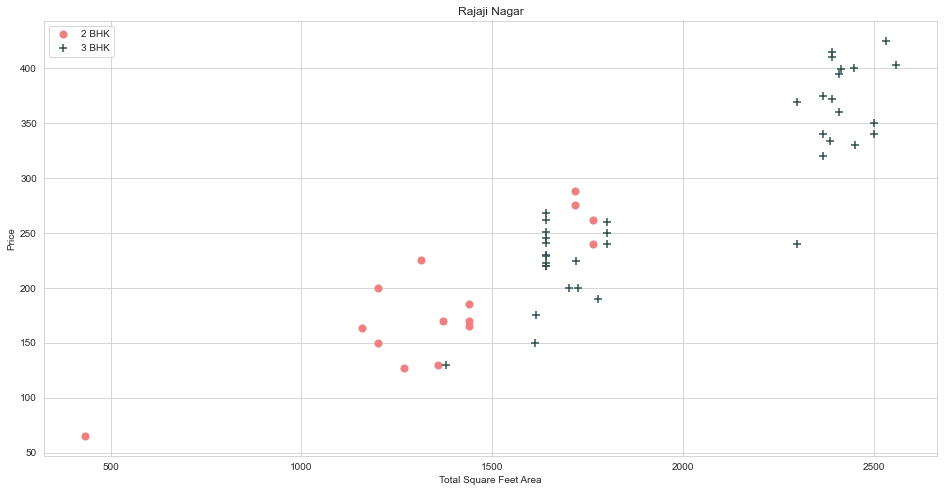

In [71]:
plot_scatter(data, 'Rajaji Nagar')

I will remove the 2BHK houses whose price_per_sqft is less than the mean price_per_sqft of 1 BHK houses:

In [72]:
def remove_bhk_outliers(df):
    exclude_ind = np.array([])
    # Data is grouped by location
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        # Dictionary with mean, std and count of each bhk type
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        # If there is enough data (more than 5 cases) in the previous size type
        # and the price per sqft is less than the mean calculated for the previous size
        # that index is appended to be removed at the end
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if (stats and stats['count']>5):
                exclude_ind = np.append(exclude_ind, bhk_df[bhk_df['price_per_sqft']<(stats['mean'])].index.values)
    return df.drop(exclude_ind, axis='index')

In [73]:
train_data = data[data['source']=='Train']
test_data = data[data['source']=='Test']

In [74]:
data = remove_bhk_outliers(train_data)
print(data.shape)
data = pd.concat([data, test_data], ignore_index=True)
print(data.shape)

(7632, 11)
(9112, 11)


Repeat the same scatter plot:

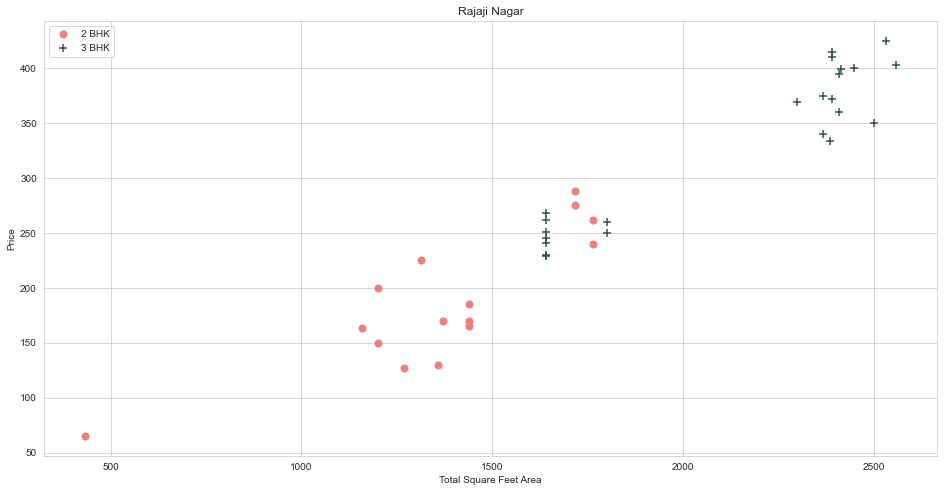

In [75]:
plot_scatter(data, 'Rajaji Nagar')

In [76]:
round(data.loc[(data['bhk']==2) & (data['location']=='Rajaji Nagar')]['price_per_sqft'].mean(skipna=True), 2)

136498.95

All of the 3 BHK points that had a price_per_sqft lower than 136498.95 have been removed. 

Text(0, 0.5, 'Count')

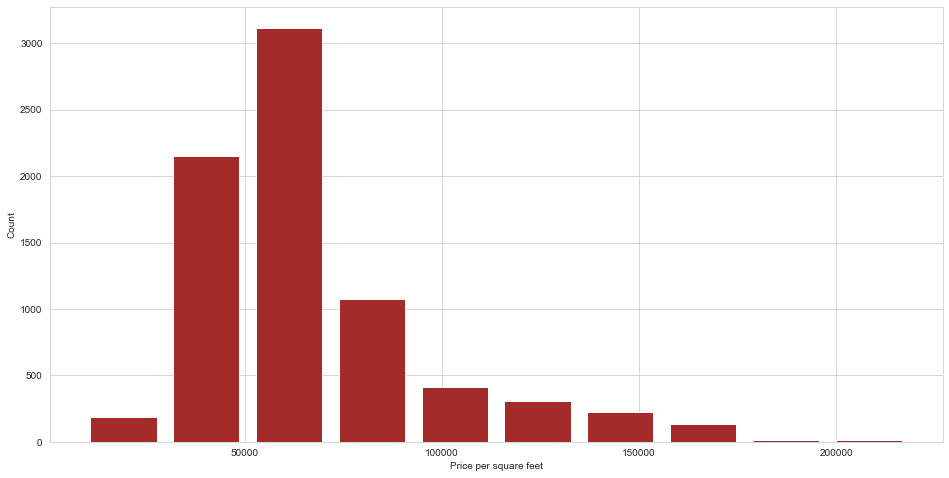

In [77]:
plt.figure(figsize=(16,8))
plt.hist(data['price_per_sqft'], rwidth=0.8, color='brown')
plt.xlabel('Price per square feet')
plt.ylabel('Count')

## Outlier removal using bath

In [78]:
data['bath'].unique()

array([ 3.,  5.,  4.,  2.,  1.,  8.,  6.,  7.,  9., 10., 14., 27., 11.,
       12., 16., 15., 13., 18.])

Text(0, 0.5, 'Count')

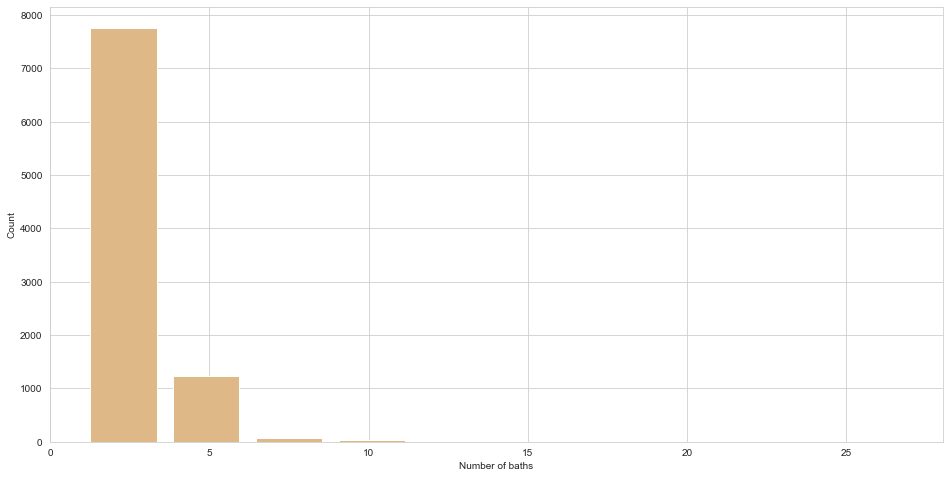

In [79]:
plt.figure(figsize=(16,8))
plt.hist(data['bath'], rwidth=0.8, color='burlywood')
plt.xlabel('Number of baths')
plt.ylabel('Count')

In [80]:
data['bath'].value_counts()

2.0     4794
3.0     2249
4.0      793
1.0      721
5.0      285
6.0      151
7.0       44
8.0       32
9.0       23
10.0       9
12.0       3
16.0       2
18.0       1
14.0       1
11.0       1
15.0       1
13.0       1
27.0       1
Name: bath, dtype: int64

I will remove all houses with more than 10 baths.

In [81]:
print(data.shape)
data = data.loc[~((data['source']=='Train') & (data['bath']>10))]
print(data.shape)

(9112, 11)
(9102, 11)


It is also unusual to have 2 more bathrooms than rooms:

In [82]:
data.loc[data['bath']>data['bhk']+2]

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,price_per_sqft,bhk,sqft_per_room
4830,11645,Plot Area,1500.0,9.0,3.0,230.0,Train,Other,153333.333333,6,250.0
5293,9990,Plot Area,1200.0,9.0,3.0,122.0,Train,Other,101666.666667,6,200.0
6867,12103,Super built-up Area,1806.0,6.0,2.0,116.0,Train,Thanisandra,64230.343300,3,602.0
7702,14089,Super built-up Area,1740.0,6.0,3.0,NaN,Test,Whitefield,NaN,3,580.0
8423,14793,Plot Area,6750.0,8.0,1.0,NaN,Test,Other,NaN,4,1687.5
8429,14714,Plot Area,2400.0,8.0,1.0,NaN,Test,Other,NaN,5,480.0


In [83]:
print(data.shape)
data = data.loc[~((data['source']=='Train') & (data['bath']>data['bhk']+2))]
print(data.shape)

(9102, 11)
(9099, 11)


In [84]:
data.to_csv('processed_data.csv', index=False)

Remove columns that aren´t needed:

In [85]:
data.drop(['price_per_sqft', 'sqft_per_room'], axis='columns', inplace=True)

# One hot encoding

## Location

In [86]:
data_loc = pd.get_dummies(data['location'])
data_loc.head()

,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
data = pd.concat([data, data_loc.drop(['Other'], axis='columns')], axis='columns')
data.head()

,first_ind,area_type,total_sqft,bath,balcony,price,source,location,bhk,1st Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,2106,Super built-up Area,1875.0,3.0,1.0,167.0,Train,1st Phase JP Nagar,3,1,...,0,0,0,0,0,0,0,0,0,0
1,2292,Built-up Area,1500.0,5.0,1.0,85.0,Train,1st Phase JP Nagar,5,1,...,0,0,0,0,0,0,0,0,0,0
2,2914,Super built-up Area,2065.0,4.0,1.0,210.0,Train,1st Phase JP Nagar,3,1,...,0,0,0,0,0,0,0,0,0,0
3,3669,Super built-up Area,2059.0,3.0,2.0,225.0,Train,1st Phase JP Nagar,3,1,...,0,0,0,0,0,0,0,0,0,0
4,4605,Super built-up Area,1394.0,2.0,1.0,100.0,Train,1st Phase JP Nagar,2,1,...,0,0,0,0,0,0,0,0,0,0


In [88]:
data.drop(['location'], axis='columns', inplace=True)
data.head()

,first_ind,area_type,total_sqft,bath,balcony,price,source,bhk,1st Phase JP Nagar,2nd Stage Nagarbhavi,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,2106,Super built-up Area,1875.0,3.0,1.0,167.0,Train,3,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2292,Built-up Area,1500.0,5.0,1.0,85.0,Train,5,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2914,Super built-up Area,2065.0,4.0,1.0,210.0,Train,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3669,Super built-up Area,2059.0,3.0,2.0,225.0,Train,3,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4605,Super built-up Area,1394.0,2.0,1.0,100.0,Train,2,1,0,...,0,0,0,0,0,0,0,0,0,0


## Area_type

In [89]:
data_area = pd.get_dummies(data['area_type'])
data_area.head()

,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [90]:
data_area.sum()

Built-up  Area          1598
Carpet  Area              57
Plot  Area              1255
Super built-up  Area    6189
dtype: int64

In [91]:
data = pd.concat([data, data_area.drop(['Carpet  Area'], axis='columns')], axis='columns')
data.drop(['area_type'], axis='columns', inplace=True)
data.head()

,first_ind,total_sqft,bath,balcony,price,source,bhk,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Phase JP Nagar,...,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur,Built-up Area,Plot Area,Super built-up Area
0,2106,1875.0,3.0,1.0,167.0,Train,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2292,1500.0,5.0,1.0,85.0,Train,5,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2914,2065.0,4.0,1.0,210.0,Train,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3669,2059.0,3.0,2.0,225.0,Train,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4605,1394.0,2.0,1.0,100.0,Train,2,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Model creation

In [92]:
# Separate the train and test dataset:
train_data = (data[data['source']=='Train'])
test_data = (data[data['source']=='Test'])

# Drop source feature
train_data.drop(['source'], axis='columns', inplace=True)
test_data.drop(['source', 'price'], axis='columns', inplace=True)

train_data.to_csv('train_processed.csv', index=False)
test_data.to_csv('test_processed.csv', index=False)

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a **generic function** which takes the algorithm and data as input and **makes the model, performs cross-validation and generates submission**.

In [93]:
#Define target:
target = 'price'

not_to_use = ['price', 'first_ind']

# Output folder:
folder = 'Processed/'
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, dtest, predictors, target, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation with 20 partitions of the data:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    dtest.to_csv(folder + filename, index=False)

## Linear Regression

In [94]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train_data.columns if x not in not_to_use]
predictors

['total_sqft',
 'bath',
 'balcony',
 'bhk',
 '1st Phase JP Nagar',
 '2nd Stage Nagarbhavi',
 '5th Phase JP Nagar',
 '6th Phase JP Nagar',
 '7th Phase JP Nagar',
 '8th Phase JP Nagar',
 '9th Phase JP Nagar',
 'Abbigere',
 'Akshaya Nagar',
 'Ambalipura',
 'Ambedkar Nagar',
 'Amruthahalli',
 'Anandapura',
 'Ananth Nagar',
 'Anekal',
 'Anjanapura',
 'Ardendale',
 'Attibele',
 'BTM 2nd Stage',
 'BTM Layout',
 'Babusapalaya',
 'Balagere',
 'Banashankari',
 'Banashankari Stage III',
 'Bannerghatta Road',
 'Basavangudi',
 'Basaveshwara Nagar',
 'Battarahalli',
 'Begur Road',
 'Bellandur',
 'Bhoganhalli',
 'Billekahalli',
 'Binny Pete',
 'Bisuvanahalli',
 'Bommanahalli',
 'Bommasandra',
 'Bommasandra Industrial Area',
 'Brookefield',
 'Budigere',
 'CV Raman Nagar',
 'Chandapura',
 'Channasandra',
 'Chikkalasandra',
 'Choodasandra',
 'Dasarahalli',
 'Devanahalli',
 'Dodda Nekkundi',
 'Doddathoguru',
 'Domlur',
 'EPIP Zone',
 'Electronic City',
 'Electronic City Phase II',
 'Electronics City Phas

In [95]:
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train_data, test_data, predictors, target, 'lr.csv')


Model Report
RMSE : 43.6
CV Score : Mean - 9.978e+15 | Std - 1.327e+16 | Min - 37.06 | Max - 5.428e+16


## Ridge Regression:

In [96]:
predictors = [x for x in train_data.columns if x not in [target]]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train_data, test_data, predictors, target, 'ridge.csv')


Model Report
RMSE : 43.91
CV Score : Mean - 54.02 | Std - 16.54 | Min - 32.74 | Max - 93.15


## Decision Tree Model:


Model Report
RMSE : 59.36
CV Score : Mean - 54.5 | Std - 28.82 | Min - 28.57 | Max - 123.8


<AxesSubplot:title={'center':'Feature Importances'}>

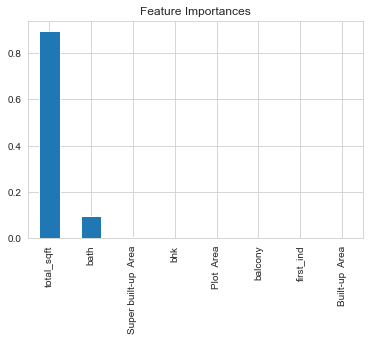

In [97]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train_data.columns if x not in [target]]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train_data, test_data, predictors, target, 'dcm.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3 = coef3.loc[coef3.values > 0]
coef3.plot(kind='bar', title='Feature Importances')

## Random Forest Model


Model Report
RMSE : 60.55
CV Score : Mean - 54.28 | Std - 30.21 | Min - 27.13 | Max - 127.3


<AxesSubplot:title={'center':'Feature Importances'}>

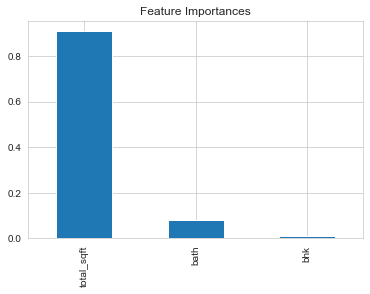

In [98]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train_data.columns if x not in [target]]
alg4 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg4, train_data, test_data, predictors, target, 'rfm.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4 = coef4.loc[coef4.values > 0.01]
coef4.plot(kind='bar', title='Feature Importances')

# Conclusion
This time the Linear Regression model has the best score.

In [99]:
sub_file = pd.read_csv('submission_test_file.csv')
model_selected = pd.read_csv('Processed/lr.csv')
print(sub_file.shape, model_selected.shape)

(1480, 11) (1480, 169)


In [101]:
sub_file.columns

Index(['first_ind', 'area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price', 'source'],
      dtype='object')

In [102]:
sub_file.drop(['price', 'source'], axis='columns', inplace=True)
sub_file.head()

,first_ind,area_type,availability,location,size,society,total_sqft,bath,balcony
0,13320,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0
1,13321,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0
2,13322,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0
3,13323,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0
4,13324,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0


In [112]:
sub_file = sub_file.merge(right = model_selected[['first_ind','price']],
                          on = 'first_ind')

In [113]:
sub_file.head()

,first_ind,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,13320,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,73.885384
1,13321,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,217.540727
2,13322,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,130.082147
3,13323,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,66.403551
4,13324,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,104.759765


In [115]:
sub_file.drop(['first_ind'], axis='columns', inplace=True)
sub_file.to_csv('Processed/submission_file.csv', index=False)